In [1]:
%autosave 0
import numpy as np
import pandas as pd

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px

from datetime import date, timedelta
from joblib import dump

import warnings
warnings.filterwarnings("ignore") 

Autosave disabled


Start Day : 28/03

Trying to predict number of new cases & deaths one day before

Working with data update everyday here : https://ourworldindata.org/coronavirus-source-data
I take the full dataset linked

In [2]:
## Today Data scrap on nb 00 
df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")

In [3]:
df.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
0,ABW,North America,Aruba,2020-03-13,2.0,2.0,NaN,0.0,0.0,NaN,...,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29
1,ABW,North America,Aruba,2020-03-19,NaN,NaN,0.286,NaN,NaN,0.0,...,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29
2,ABW,North America,Aruba,2020-03-20,4.0,2.0,0.286,0.0,0.0,0.0,...,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29


In [4]:
df.tail(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
41167,NaN,NaN,International,2020-08-31,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41168,NaN,NaN,International,2020-09-01,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41169,NaN,NaN,International,2020-09-02,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df['location'].unique()

array(['Aruba', 'Afghanistan', 'Angola', 'Anguilla', 'Albania', 'Andorra',
       'United Arab Emirates', 'Argentina', 'Armenia',
       'Antigua and Barbuda', 'Australia', 'Austria', 'Azerbaijan',
       'Burundi', 'Belgium', 'Benin', 'Bonaire Sint Eustatius and Saba',
       'Burkina Faso', 'Bangladesh', 'Bulgaria', 'Bahrain', 'Bahamas',
       'Bosnia and Herzegovina', 'Belarus', 'Belize', 'Bermuda',
       'Bolivia', 'Brazil', 'Barbados', 'Brunei', 'Bhutan', 'Botswana',
       'Central African Republic', 'Canada', 'Switzerland', 'Chile',
       'China', "Cote d'Ivoire", 'Cameroon',
       'Democratic Republic of Congo', 'Congo', 'Colombia', 'Comoros',
       'Cape Verde', 'Costa Rica', 'Cuba', 'Curacao', 'Cayman Islands',
       'Cyprus', 'Czech Republic', 'Germany', 'Djibouti', 'Dominica',
       'Denmark', 'Dominican Republic', 'Algeria', 'Ecuador', 'Egypt',
       'Eritrea', 'Western Sahara', 'Spain', 'Estonia', 'Ethiopia',
       'Finland', 'Fiji', 'Falkland Islands', 'France',

# Data Exploration

In [6]:
def massBalance(subject,df,country):
    """ Plot evolution of data by columns
    params :
        subject = name of cols concerned by the plot
        df = The Dataframe
        country = Name of location isolated for the plot
    """
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.line(x=df["date"], y=df[f"{subject}"])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [7]:
## Plotly graph will be not display on Git ##
# massBalance("total_deaths",df,"World")
# massBalance("total_deaths",df,"France")
# massBalance("total_deaths",df,"China")
# massBalance("total_deaths",df,"Italy")
# massBalance("total_deaths",df,"Spain")
# massBalance("total_deaths",df,"United States")
# massBalance("total_deaths",df,"Germany")
# massBalance("total_deaths",df,"Iran")
# massBalance("total_deaths",df,"Turkey")
# massBalance("total_deaths",df,"Brazil")

In [8]:
## Plotly graph will be not display on Git ##
# massBalance("total_cases",df,"World")
# massBalance("total_cases",df,"France")
# massBalance("total_cases",df,"China")
# massBalance("total_cases",df,"Italy")
# massBalance("total_cases",df,"Spain")
# massBalance("total_cases",df,"United States")
# massBalance("total_cases",df,"United Kingdom")
# massBalance("total_cases",df,"Germany")
# massBalance("total_cases",df,"Iran")
# massBalance("total_cases",df,"Turkey")
# massBalance("total_cases",df,"Brazil")

In [9]:
def newOverTime(subject,df,country):
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.bar(df, x=df["date"], y=df[f'{subject}'])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [10]:
## Plotly graph will be not display on Git ##
# newOverTime("new_cases",df,"World")
# newOverTime("new_cases",df,"France")
# newOverTime("new_cases",df,"China")
# newOverTime("new_cases",df,"Italy")
# newOverTime("new_cases",df,"Spain")
# newOverTime("new_cases",df,"United States")
# newOverTime("new_cases",df,"United Kingdom")
# newOverTime("new_cases",df,"Germany")
# newOverTime("new_cases",df,"Iran")
# newOverTime("new_cases",df,"Turkey")
# newOverTime("new_cases",df,"Brazil")

In [11]:
## Plotly graph will be not display on Git ##
# newOverTime("new_deaths",df,"World")
# newOverTime("new_deaths",df,"France")
# newOverTime("new_deaths",df,"China")
# newOverTime("new_deaths",df,"Italy")
# newOverTime("new_deaths",df,"Spain")
# newOverTime("new_deaths",df,"United States")
# newOverTime("new_deaths",df,"United Kingdom")
# newOverTime("new_deaths",df,"Germany")
# newOverTime("new_deaths",df,"Iran")
# newOverTime("new_deaths",df,"Turkey")
# newOverTime("new_deaths",df,"Brazil")

In [12]:
def worldrep(subject,graph_long=5,val_larg=1000000,df=df):
    fidf_mod = df.sort_values(subject, axis=0, ascending =False).head(500)
    f, ax = plt.subplots(figsize=(15, graph_long))

    ax.set(xlim=(0, val_larg), 
           ylabel= "Pays",
           xlabel= subject,
           Title= (f"{subject} by country")
          )
    ax.legend()
    sns.despine(top=True)
    ax = sns.barplot(x=fidf_mod[subject], y=fidf_mod["location"])


No handles with labels found to put in legend.


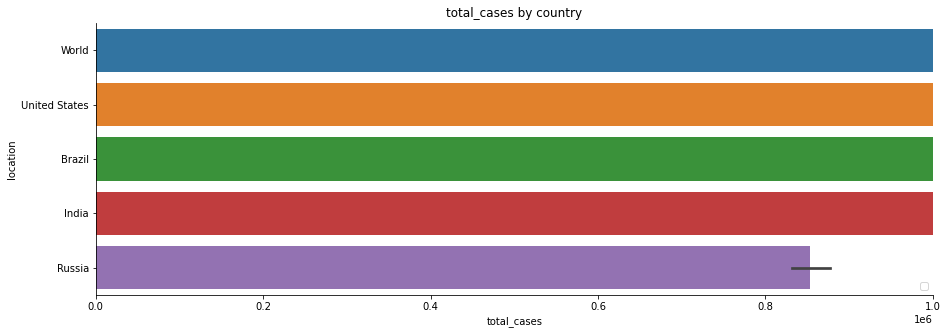

In [13]:
worldrep("total_cases")

No handles with labels found to put in legend.


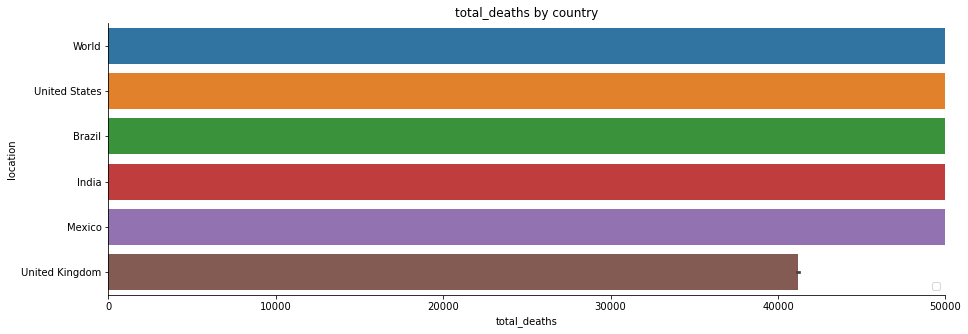

In [14]:
worldrep("total_deaths",val_larg=50000)

In [15]:
dds = df[df["date"].isin([f'{date.today()}'])]

No handles with labels found to put in legend.


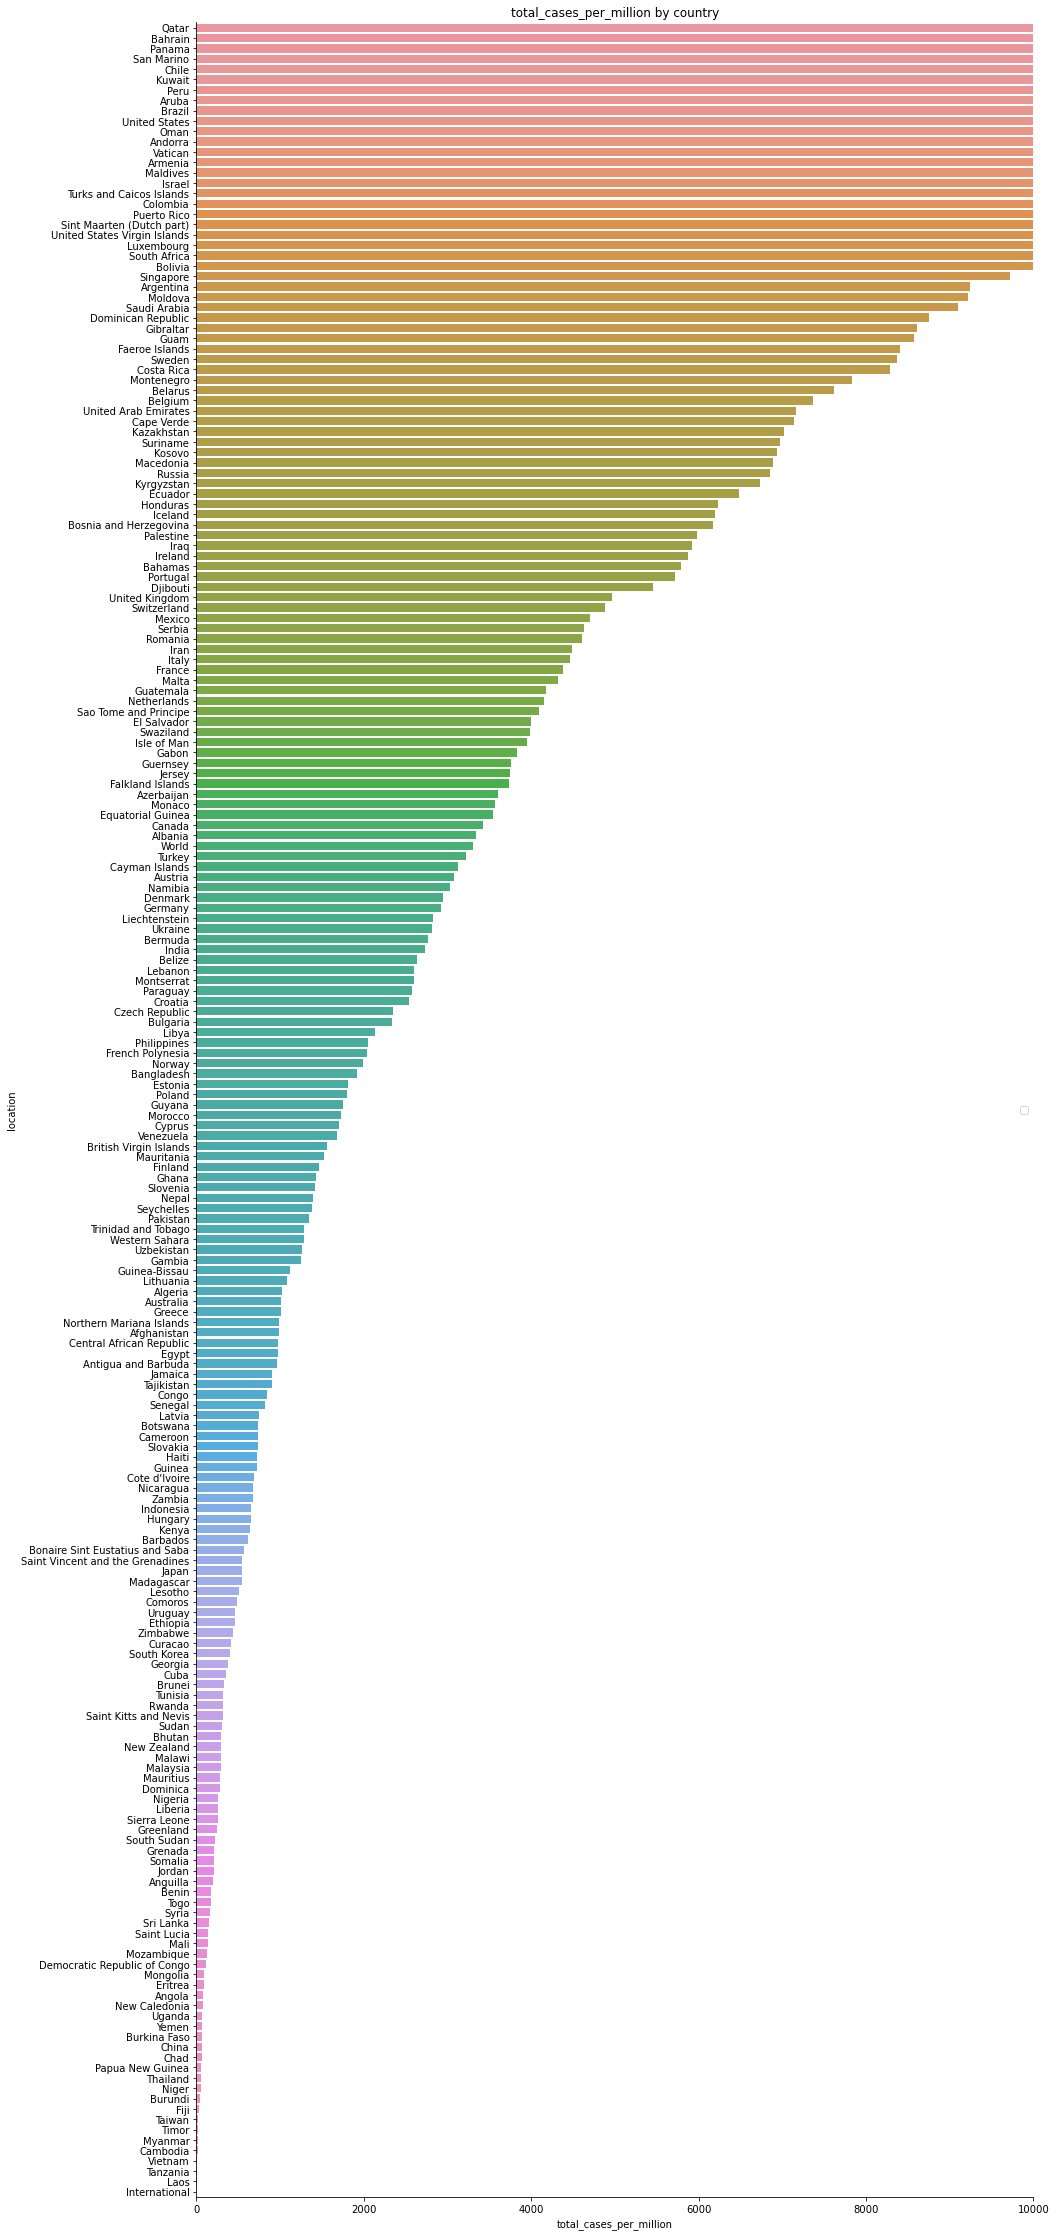

In [16]:
try:
    worldrep("total_cases_per_million",graph_long=40,val_larg=10000,df=dds)
except:
    print("Not today")

No handles with labels found to put in legend.


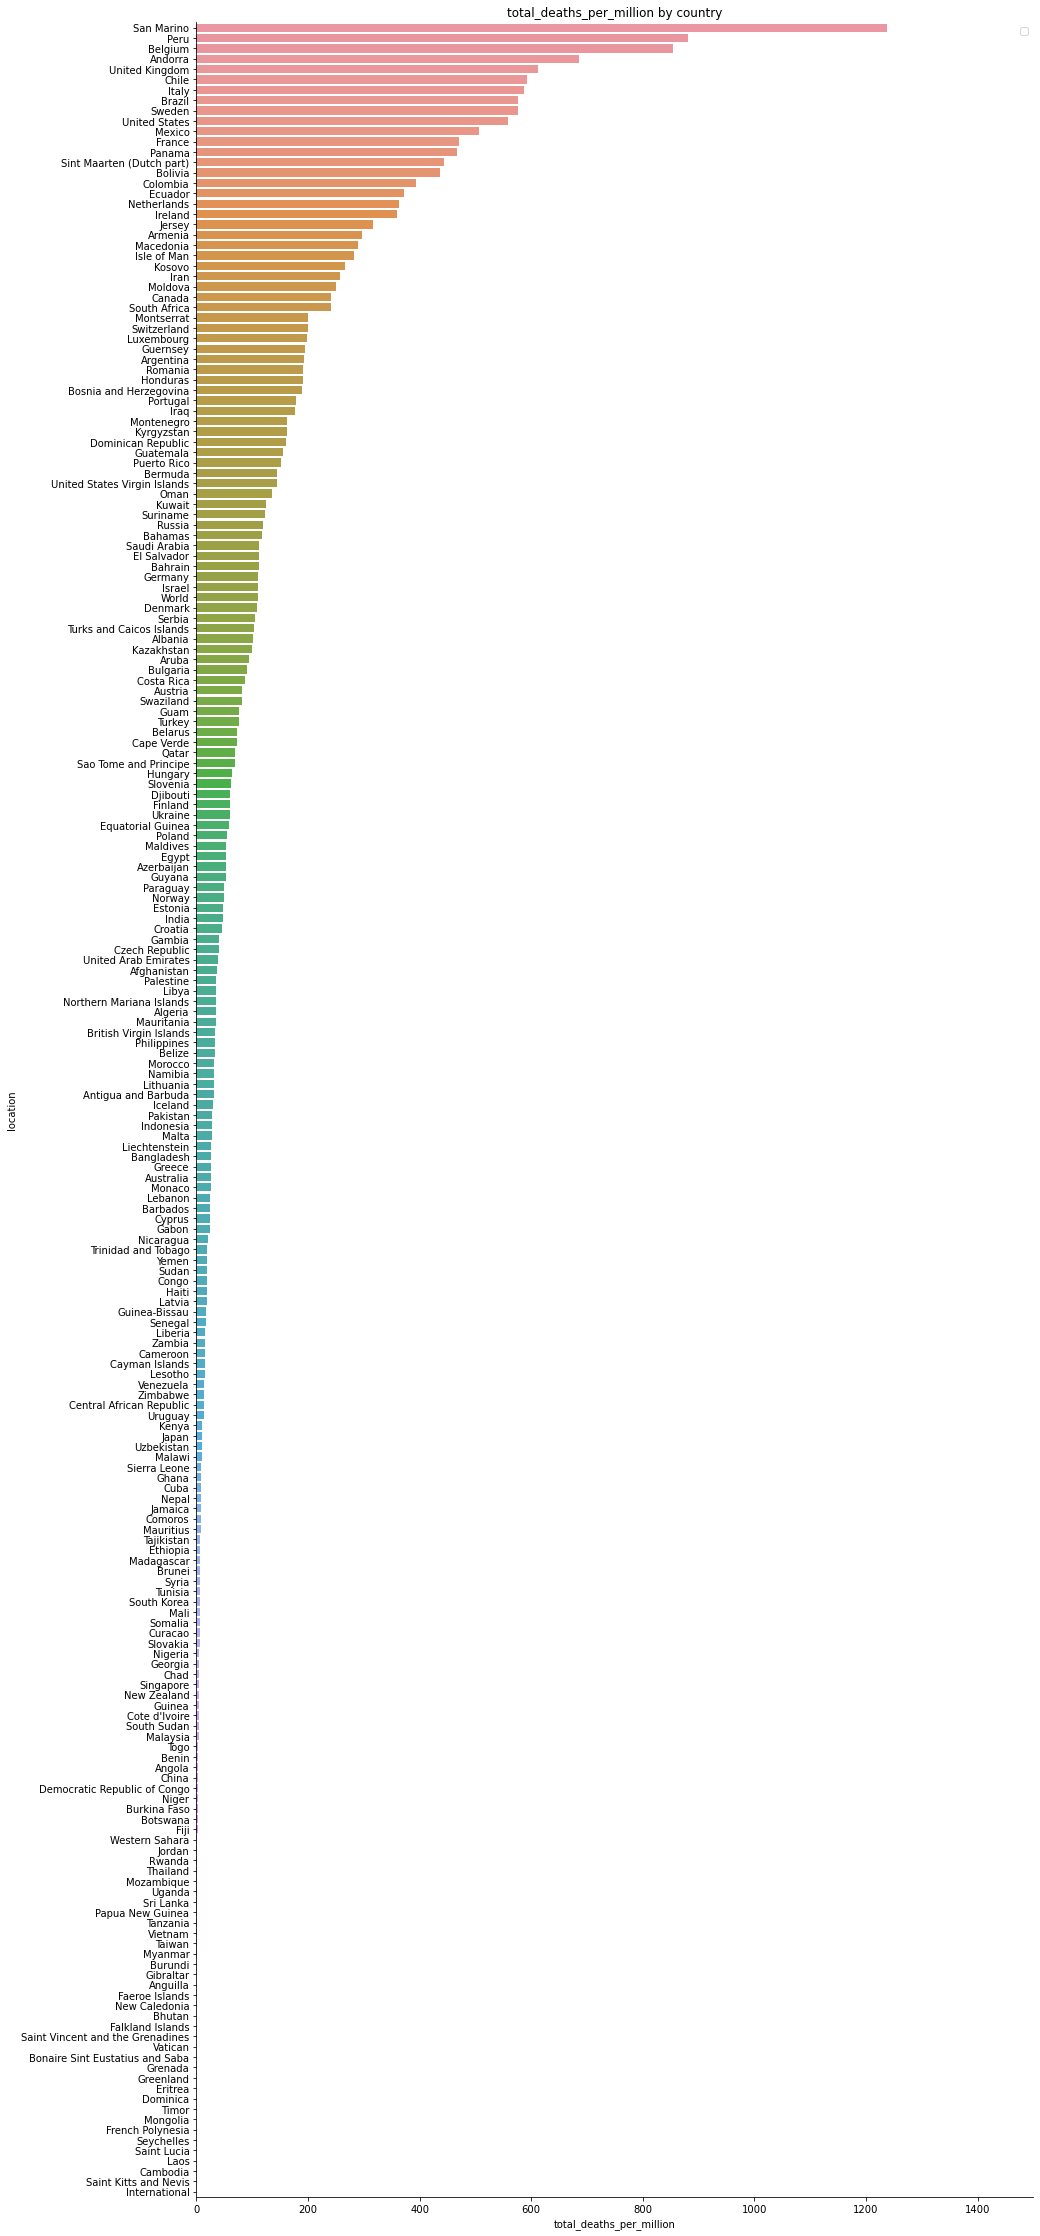

In [17]:
try :
    worldrep("total_deaths_per_million",graph_long=40,val_larg=1500,df=dds)
    is_full_data = True
except:
    is_full_data = False
    print("not today")

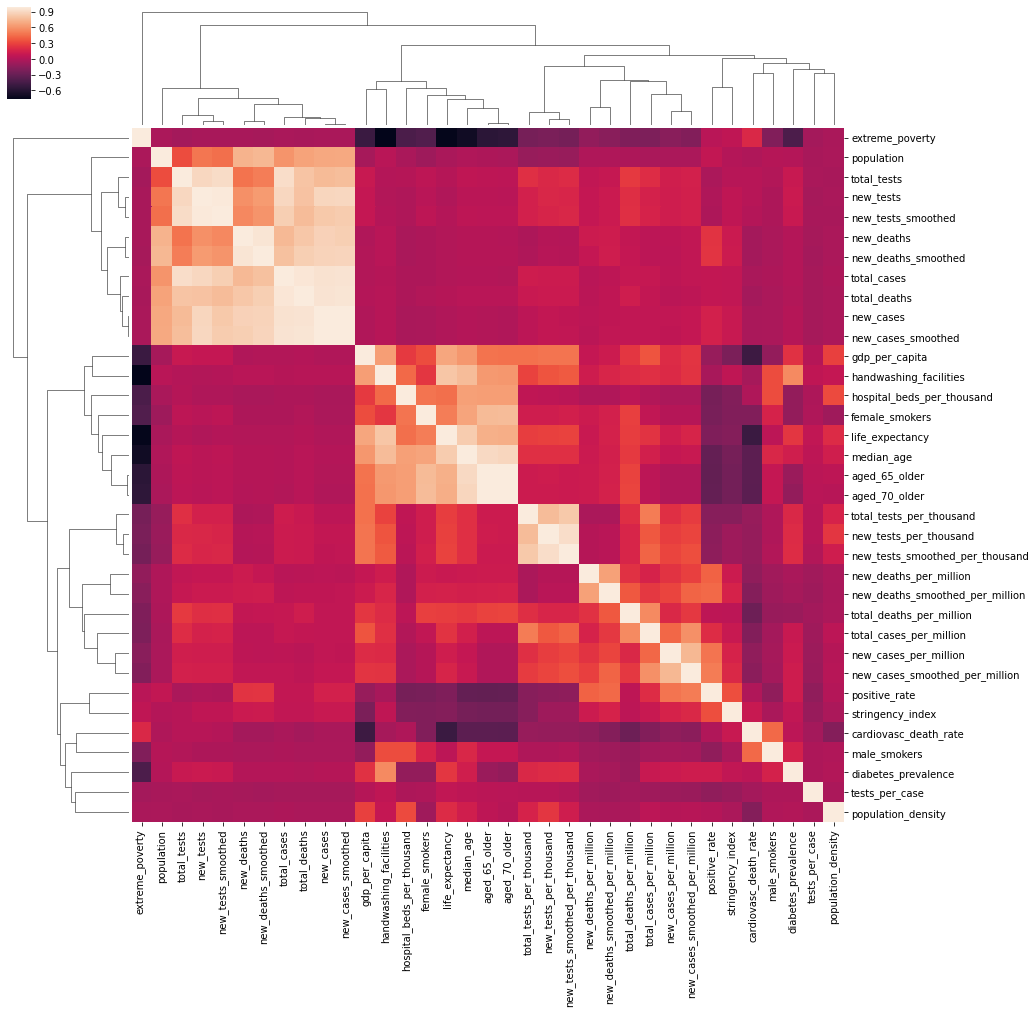

In [18]:
if is_full_data:
    corr = df.corr()
    sns.clustermap(corr,figsize=(15, 15))
else :
    print("not today")

# Modeling routines

In [19]:
def createModel(subject,periode,country,n_splits=3,max_iter=5000):
    
    df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")
    df = df[df['location'].isin([f"{country}"])] 
    vals = df[[f"{subject}"]].values
    
    imp = SimpleImputer(missing_values=np.nan, strategy='constant')
    vals = imp.fit_transform(vals)
    
    hisShape = vals.shape[0]
    x_train = []
    y_train = []

    for i in range(periode,hisShape):
        x_train.append(vals[(i-periode):i,0]) 
        y_train.append(vals[i,0])

    x_train = np.array(x_train) 
    y_train = np.array(y_train)
    
    ###############################################################
    model = ElasticNet(random_state=0,max_iter=max_iter) 
    # tol=0.01 by reducing this hp warning disapear, pred will be highter 
    ###############################################################
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = cross_val_score(model, x_train, y_train, cv=tscv)
    print(f"R^2: {scores.mean()} (+/- {scores.std()})")
    
    model.fit(x_train,y_train)
    print("Coef : ",model.coef_)
    
    return vals, x_train,y_train, model

In [20]:
def predicTomorow(vals,model,periode):
    tmw = vals[-periode:]
    lili = []
    for i in tmw:
        lili.append(int(i))
    lili = np.array(lili).reshape(1, -1) 
    res = int(model.predict(lili))
    last_day = lili[0][periode-1]
    diff_betw = res-last_day
    print(f"{periode} Last_days : ",lili)
    print("Today : ",last_day)
    print("Prediction + : ",diff_betw)
    print("Tomorow : ",res)
    return last_day, res

In [21]:
def conbine(subject,periode,country):
    vals, x_train, y_train, model = createModel(subject,periode,country)
    last_day, ress = predicTomorow(vals,model,periode)
    return last_day, ress

In [22]:
def fullRoutines(df,periode,country):
    print(f"********* For {country} **************")
    print("                                     ")
    print("--------- Total Cases -----------------")
    print("                                     ")
    last_day_cases, res1 = conbine("total_cases",periode,f"{country}")
    print("                                     ")
    print("--------- Total Death -----------------")
    print("                                     ")
    last_day_death, res2 = conbine("total_deaths",periode,f"{country}")
    print("                                     ")
    return last_day_cases, last_day_death, res1, res2

# Prediction Tomorow

In [23]:
periode = 3

In [24]:
last_day_cases, last_day_death, res1ww, res2ww = fullRoutines(df,periode,"World")
world_data = last_day_cases, last_day_death, res1ww, res2ww

********* For World **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9993055985927161 (+/- 0.0006247430962164202)
Coef :  [1.03675634e+00 9.23463400e-05 9.69973172e-05]
3 Last_days :  [[25275711 25517643 25776601]]
Today :  25776601
Prediction + :  517570
Tomorow :  26294171
                                     
--------- Total Death -----------------
                                     
R^2: 0.9996524722124627 (+/- 6.341461966069042e-05)
Coef :  [0.05634535 0.46107224 0.49265996]
3 Last_days :  [[846916 850967 857448]]
Today :  857448
Prediction + :  7701
Tomorow :  865149
                                     


In [25]:
last_day_casesfr, last_day_deathfr, res1fr, res2fr = fullRoutines(df,periode,"France")
french_data = last_day_casesfr, last_day_deathfr, res1fr, res2fr

********* For France **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.994824250750867 (+/- 0.002289147488155553)
Coef :  [-0.70612194  0.7599329   0.94841472]
3 Last_days :  [[277943 281025 286007]]
Today :  286007
Prediction + :  2747
Tomorow :  288754
                                     
--------- Total Death -----------------
                                     
R^2: 0.337292813875622 (+/- 0.9284783607308458)
Coef :  [-0.75184     0.78868854  0.96218614]
3 Last_days :  [[30606 30635 30661]]
Today :  30661
Prediction + :  43
Tomorow :  30704
                                     


In [26]:
last_day_casesch, last_day_deathch, res1ch, res2ch = fullRoutines(df,periode,"China")
china_data = last_day_casesch, last_day_deathch, res1ch, res2ch

********* For China **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9116746962308909 (+/- 0.07086392869003694)
Coef :  [-0.32533476 -0.01862545  1.33822769]
3 Last_days :  [[89895 89914 89934]]
Today :  89934
Prediction + :  25
Tomorow :  89959
                                     
--------- Total Death -----------------
                                     
R^2: -182.87126067329677 (+/- 259.89490783095715)
Coef :  [-0.07705666  0.01244302  1.0565052 ]
3 Last_days :  [[4722 4723 4724]]
Today :  4724
Prediction + :  6
Tomorow :  4730
                                     


In [27]:
last_day_casesit, last_day_deathit, res1it, res2it = fullRoutines(df,periode,"Italy")
italy_data = last_day_casesit, last_day_deathit, res1it, res2it

********* For Italy **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.5357851510402858 (+/- 0.6553095616533331)
Coef :  [-0.8266874   0.89962356  0.9263344 ]
3 Last_days :  [[268218 269214 270189]]
Today :  270189
Prediction + :  940
Tomorow :  271129
                                     
--------- Total Death -----------------
                                     
R^2: 0.8173987324463149 (+/- 0.23158250329408045)
Coef :  [-0.82827654  0.8994414   0.92794215]
3 Last_days :  [[35477 35483 35491]]
Today :  35491
Prediction + :  26
Tomorow :  35517
                                     


In [28]:
try:
    last_day_casessp, last_day_deathsp, res1sp, res2sp = fullRoutines(df,periode,"Spain")
    spain_data = last_day_casessp, last_day_deathsp, res1sp, res2sp
except:
    print("No spain update")

********* For Spain **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9726488026498835 (+/- 0.028200418944569844)
Coef :  [-0.50127846  0.31637776  1.18777704]
3 Last_days :  [[439286 462858 470973]]
Today :  470973
Prediction + :  14878
Tomorow :  485851
                                     
--------- Total Death -----------------
                                     
R^2: 0.06315400861566871 (+/- 1.0809043855353904)
Coef :  [-0.72521164  0.6262878   1.09793477]
3 Last_days :  [[29011 29094 29152]]
Today :  29152
Prediction + :  74
Tomorow :  29226
                                     


In [29]:
last_day_casesus, last_day_deathus, res1us, res2us = fullRoutines(df,periode,"United States")
usa_data = last_day_casesus, last_day_deathus, res1us, res2us

********* For United States **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9890951224780625 (+/- 0.015071191967007838)
Coef :  [0.07478388 0.46485992 0.47594454]
3 Last_days :  [[5997163 6031013 6075652]]
Today :  6075652
Prediction + :  82077
Tomorow :  6157729
                                     
--------- Total Death -----------------
                                     
R^2: 0.43617388601854984 (+/- 0.7961582745765956)
Coef :  [-0.52895272  0.72573154  0.80580389]
3 Last_days :  [[183069 183598 184689]]
Today :  184689
Prediction + :  872
Tomorow :  185561
                                     


In [30]:
last_day_casesuk, last_day_deathuk, res1uk, res2uk = fullRoutines(df,periode,"United Kingdom")
uk_data = last_day_casesuk, last_day_deathuk, res1uk, res2uk

********* For United Kingdom **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9555823446062123 (+/- 0.06149232467952982)
Coef :  [-0.73114823  0.85330203  0.87801144]
3 Last_days :  [[334467 335873 337168]]
Today :  337168
Prediction + :  1447
Tomorow :  338615
                                     
--------- Total Death -----------------
                                     
R^2: 0.38027327702767305 (+/- 0.8379405771989855)
Coef :  [-0.77164537  0.83179716  0.93923505]
3 Last_days :  [[41499 41501 41504]]
Today :  41504
Prediction + :  38
Tomorow :  41542
                                     


In [31]:
last_day_casesger, last_day_deathger, res1ger, res2ger = fullRoutines(df,periode,"Germany")
ger_data = last_day_casesger, last_day_deathger, res1ger, res2ger

********* For Germany **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.998702528492106 (+/- 0.0006607287852207865)
Coef :  [-0.79645546  0.85705114  0.93909502]
3 Last_days :  [[242381 243599 244855]]
Today :  244855
Prediction + :  1127
Tomorow :  245982
                                     
--------- Total Death -----------------
                                     
R^2: 0.3883203080304789 (+/- 0.8536025366008139)
Coef :  [-0.79107893  0.84106008  0.94933706]
3 Last_days :  [[9298 9302 9313]]
Today :  9313
Prediction + :  9
Tomorow :  9322
                                     


In [32]:
last_day_casesIran, last_day_deathIran, res1Iran, res2Iran = fullRoutines(df,periode,"Iran")
Iran_data = last_day_casesIran, last_day_deathIran, res1Iran, res2Iran

********* For Iran **************
                                     
--------- Total Cases -----------------
                                     
R^2: -1.3084305336999489 (+/- 3.2632849768050987)
Coef :  [0.22761778 0.39172863 0.39213395]
3 Last_days :  [[373570 375212 376894]]
Today :  376894
Prediction + :  4291
Tomorow :  381185
                                     
--------- Total Death -----------------
                                     
R^2: 0.9123354404974297 (+/- 0.12334521337098484)
Coef :  [0.01097016 0.50386613 0.49697009]
3 Last_days :  [[21462 21571 21672]]
Today :  21672
Prediction + :  256
Tomorow :  21928
                                     


In [33]:
last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk = fullRoutines(df,periode,"Turkey")
Turk_data = last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk

********* For Turkey **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9984983213525672 (+/- 0.0018250877294874951)
Coef :  [-0.73216726  0.8461172   0.88342498]
3 Last_days :  [[268546 270133 271705]]
Today :  271705
Prediction + :  1302
Tomorow :  273007
                                     
--------- Total Death -----------------
                                     
R^2: 0.9990484167863961 (+/- 0.0007792594806965)
Coef :  [-0.81031062  0.89278133  0.91476446]
3 Last_days :  [[6326 6370 6417]]
Today :  6417
Prediction + :  35
Tomorow :  6452
                                     


In [34]:
last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz = fullRoutines(df,periode,"Brazil")
Braz_data = last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz

********* For Brazil **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.4581324407542262 (+/- 0.7612728268517325)
Coef :  [-0.1421685   0.50370925  0.65448272]
3 Last_days :  [[3862311 3908272 3950931]]
Today :  3950931
Prediction + :  60839
Tomorow :  4011770
                                     
--------- Total Death -----------------
                                     
R^2: 0.493756138069904 (+/- 0.710146500238814)
Coef :  [-0.11850718  0.51954584  0.61109886]
3 Last_days :  [[120828 121381 122596]]
Today :  122596
Prediction + :  1329
Tomorow :  123925
                                     


In [35]:
model_data = [world_data, french_data, italy_data, spain_data, usa_data,
              china_data, uk_data, ger_data, Iran_data, Turk_data, Braz_data]

In [36]:
model_data

[(25776601, 857448, 26294171, 865149),
 (286007, 30661, 288754, 30704),
 (270189, 35491, 271129, 35517),
 (470973, 29152, 485851, 29226),
 (6075652, 184689, 6157729, 185561),
 (89934, 4724, 89959, 4730),
 (337168, 41504, 338615, 41542),
 (244855, 9313, 245982, 9322),
 (376894, 21672, 381185, 21928),
 (271705, 6417, 273007, 6452),
 (3950931, 122596, 4011770, 123925)]

In [37]:
# dump(model_data, "endPoint/CovidDataPred.joblib")

In [38]:
def popPred(country,rez1,rez2):
    pop_pred = pd.DataFrame()

    pop_pred.loc[0,"date"] = date.today()
    pop_pred.loc[0,"country"] = country
    pop_pred.loc[0,"total_cases_predict"] = rez1
    pop_pred.loc[0,"total_cases_real"] = 0
    pop_pred.loc[0,"total_deaths_predict"] = rez2
    pop_pred.loc[0,"total_deaths_real"] = 0
    pop_pred.loc[0,"error_abs_cases"] = 0
    pop_pred.loc[0,"error_abs_deaths"] = 0
    
    return pop_pred

In [39]:
df_pop_pred1 = popPred("France",res1fr, res2fr)
df_pop_pred2 = popPred("China",res1ch, res2ch)
df_pop_pred3 = popPred("Italy",res1it, res2it)
df_pop_pred4 = popPred("Spain",res1sp, res2sp)
df_pop_pred5 = popPred("United States",res1us, res2us)
df_pop_pred6 = popPred("World",res1ww, res2ww)
df_pop_pred7 = popPred("United Kingdom",res1uk, res2uk)
df_pop_pred8 = popPred("Germany",res1ger, res2ger)
df_pop_pred9 = popPred("Iran",res1Iran, res2Iran)
df_pop_pred10 = popPred("Turkey",res1Turk, res2Turk)
df_pop_pred11 = popPred("Brazil",res1Braz, res2Braz)

frames = [df_pop_pred1, df_pop_pred2, df_pop_pred3, df_pop_pred4,
          df_pop_pred5, df_pop_pred6, df_pop_pred7, df_pop_pred8,
          df_pop_pred9, df_pop_pred10, df_pop_pred11]

predpred = pd.concat(frames)
predpred

,date,country,total_cases_predict,total_cases_real,total_deaths_predict,total_deaths_real,error_abs_cases,error_abs_deaths
0,2020-09-02,France,288754.0,0.0,30704.0,0.0,0.0,0.0
0,2020-09-02,China,89959.0,0.0,4730.0,0.0,0.0,0.0
0,2020-09-02,Italy,271129.0,0.0,35517.0,0.0,0.0,0.0
0,2020-09-02,Spain,485851.0,0.0,29226.0,0.0,0.0,0.0
0,2020-09-02,United States,6157729.0,0.0,185561.0,0.0,0.0,0.0
0,2020-09-02,World,26294171.0,0.0,865149.0,0.0,0.0,0.0
0,2020-09-02,United Kingdom,338615.0,0.0,41542.0,0.0,0.0,0.0
0,2020-09-02,Germany,245982.0,0.0,9322.0,0.0,0.0,0.0
0,2020-09-02,Iran,381185.0,0.0,21928.0,0.0,0.0,0.0
0,2020-09-02,Turkey,273007.0,0.0,6452.0,0.0,0.0,0.0


In [40]:
predpred.to_csv(f"AzureSC\\Pred\\predDf{date.today()}.csv")